In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools

# Define the ChebyshevKANLayer class
class ChebyshevKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x), x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        x = x.view(-1, self.inputdim)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(-1, self.outdim)
        return y

In [2]:
class ChebyshevKANModel(nn.Module):
    def __init__(self, degree):
        super(ChebyshevKANModel, self).__init__()
        self.chebyshevkan1 = ChebyshevKANLayer(28*28, 64, degree)
        self.layernorm1 = nn.LayerNorm(64)
        self.chebyshevkan2 = ChebyshevKANLayer(64, 10, degree)
        self.layernorm2 = nn.LayerNorm(10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.chebyshevkan1(x)
        x = self.layernorm1(x)
        x = self.relu(x)
        x = self.chebyshevkan2(x)
        x = self.layernorm2(x)
        return x

In [3]:
# Training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss / len(test_loader), correct / len(test_loader.dataset)

# Data loading and transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3,), (0.2,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33368174.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1029636.41it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8376502.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2405066.12it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Hyperparameters
learning_rate = 0.001
batch_size = 32
degree = 2

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Initialize the model, criterion, and optimizer
model = ChebyshevKANModel(degree).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
epochs = 10
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

Epoch 1, Train Loss: 0.4384, Test Loss: 0.2184, Test Acc: 0.94
Epoch 2, Train Loss: 0.1948, Test Loss: 0.1547, Test Acc: 0.96
Epoch 3, Train Loss: 0.1449, Test Loss: 0.1639, Test Acc: 0.95
Epoch 4, Train Loss: 0.1183, Test Loss: 0.1358, Test Acc: 0.96
Epoch 5, Train Loss: 0.0992, Test Loss: 0.1201, Test Acc: 0.96
Epoch 6, Train Loss: 0.0839, Test Loss: 0.1288, Test Acc: 0.96
Epoch 7, Train Loss: 0.0748, Test Loss: 0.1191, Test Acc: 0.96
Epoch 8, Train Loss: 0.0662, Test Loss: 0.1378, Test Acc: 0.96
Epoch 9, Train Loss: 0.0584, Test Loss: 0.1095, Test Acc: 0.97
Epoch 10, Train Loss: 0.0525, Test Loss: 0.1187, Test Acc: 0.97


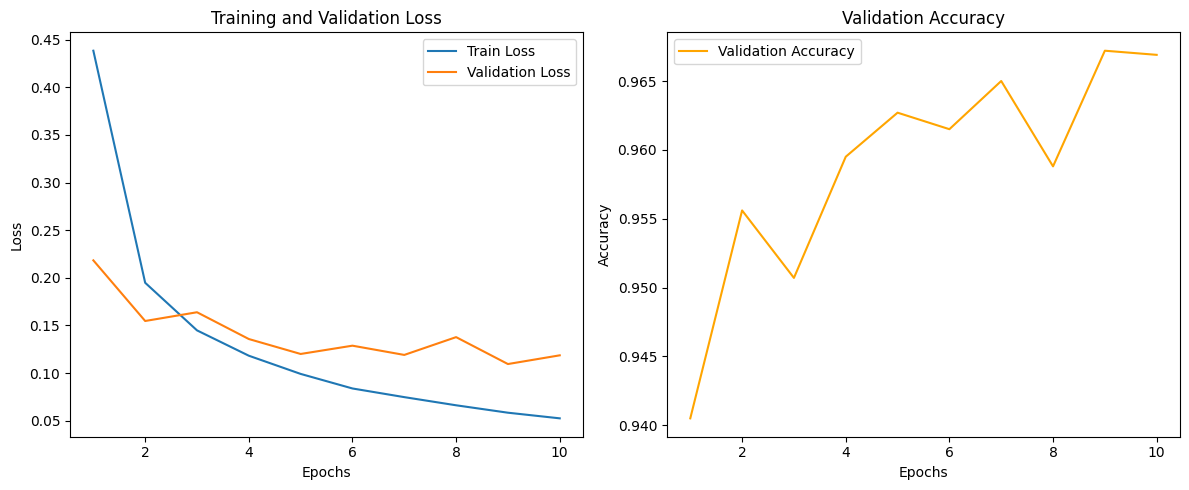

In [5]:
import matplotlib.pyplot as plt
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()